# Fake News Detection - Feature Engineering

This notebook explores different feature extraction techniques:
- TF-IDF (Term Frequency-Inverse Document Frequency)
- Word2Vec embeddings
- BERT embeddings (optional)

In [1]:
# Import libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

%matplotlib inline

## 1. Load Processed Data

In [2]:
# Load preprocessed data
df = pd.read_csv('../data/processed/processed_news.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (44715, 11)
Columns: ['title', 'text', 'subject', 'date', 'label', 'source', 'full_text', 'cleaned_text', 'word_count', 'char_count', 'avg_word_length']


,title,text,subject,date,label,source,full_text,cleaned_text,word_count,char_count,avg_word_length
0,"Trump Belittles Female Veteran, Embarrasses H...","Donald Trump always believes he s right, no ma...",News,"September 7, 2016",0,fake,"Trump Belittles Female Veteran, Embarrasses Hi...",trump belittles female veteran embarrasses tot...,180,1330,6.394444
1,ZING! Sarah Sanders Slices and Dices Hack Repo...,You d think reporters would learn to ask quest...,politics,"Nov 17, 2017",0,fake,ZING! Sarah Sanders Slices and Dices Hack Repo...,zing sarah sander slice dice hack reporter awe...,258,1830,6.096899
2,MEDIA COULDN’T BE FOUND DURING BENGHAZI SCANDA...,Not that anyone should be surprised by the lap...,Government News,"Apr 14, 2015",0,fake,MEDIA COULDN’T BE FOUND DURING BENGHAZI SCANDA...,medium ’ found benghazi scandal…but watch spri...,34,219,5.470588
3,Judge Rules That It’s Very Expensive To Be Th...,For years if not decades liberals have com...,News,"September 1, 2016",0,fake,Judge Rules That It’s Very Expensive To Be The...,judge rule ’ expensive victim mass shooting ye...,218,1545,6.091743
4,"Trump Campaign Chairman Goes Rogue, Is Caught...",It appears that the Bundy militia has finally ...,News,"January 7, 2016",0,fake,"Trump Campaign Chairman Goes Rogue, Is Caught ...",trump campaign chairman go rogue caught joinin...,309,2330,6.543689


## 2. TF-IDF Features

In [3]:
from src.preprocessing.feature_extractor import TFIDFExtractor

# Initialize TF-IDF extractor
tfidf = TFIDFExtractor(max_features=5000, ngram_range=(1, 2))

# Extract features
X_tfidf = tfidf.fit_transform(df['cleaned_text'].values)
y = df['label'].values

print(f"TF-IDF matrix shape: {X_tfidf.shape}")
print(f"Labels shape: {y.shape}")

📊 Fitting TF-IDF vectorizer (max_features=5000)...
   ✅ TF-IDF matrix shape: (44715, 5000)
TF-IDF matrix shape: (44715, 5000)
Labels shape: (44715,)


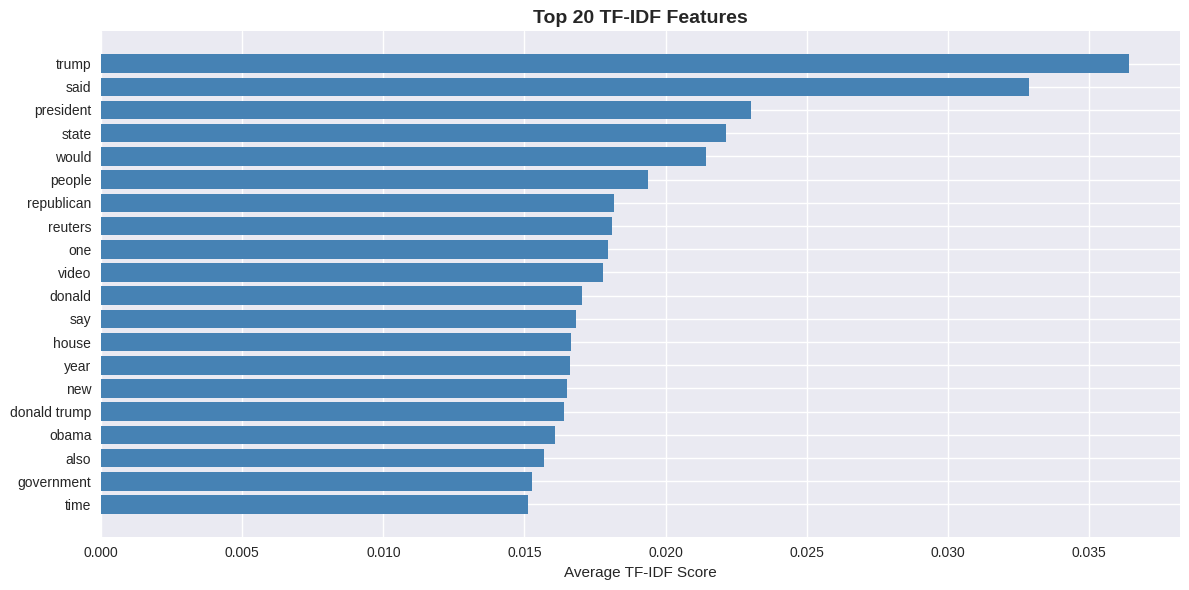


Top 20 TF-IDF Features:
trump: 0.0364
said: 0.0329
president: 0.0230
state: 0.0222
would: 0.0214
people: 0.0194
republican: 0.0182
reuters: 0.0181
one: 0.0180
video: 0.0178
donald: 0.0171
say: 0.0168
house: 0.0166
year: 0.0166
new: 0.0165
donald trump: 0.0164
obama: 0.0161
also: 0.0157
government: 0.0153
time: 0.0151


In [4]:
# Get top TF-IDF features
feature_names = tfidf.get_feature_names()

# Calculate average TF-IDF scores
tfidf_scores = X_tfidf.mean(axis=0).A1
top_indices = tfidf_scores.argsort()[-20:][::-1]

top_features = [(feature_names[i], tfidf_scores[i]) for i in top_indices]

# Plot top features
plt.figure(figsize=(12, 6))
words, scores = zip(*top_features)
plt.barh(words, scores, color='steelblue')
plt.xlabel('Average TF-IDF Score')
plt.title('Top 20 TF-IDF Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 20 TF-IDF Features:")
for word, score in top_features:
    print(f"{word}: {score:.4f}")

## 3. Word2Vec Features

In [5]:
from src.preprocessing.feature_extractor import Word2VecExtractor

# Sample data for faster processing (remove sampling for full dataset)
sample_size = 5000
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

# Initialize Word2Vec extractor
w2v = Word2VecExtractor(vector_size=100, window=5, min_count=5)

# Extract features
X_w2v = w2v.fit_transform(df_sample['cleaned_text'].values)
y_sample = df_sample['label'].values

print(f"Word2Vec matrix shape: {X_w2v.shape}")
print(f"Labels shape: {y_sample.shape}")

🔤 Training Word2Vec model (vector_size=100)...
   ✅ Word2Vec model trained with 15861 words
Word2Vec matrix shape: (5000, 100)
Labels shape: (5000,)


In [6]:
# Check most similar words
test_words = ['trump', 'obama', 'news', 'fake', 'real', 'government']

print("Most Similar Words (Word2Vec):")
print("="*70)

for word in test_words:
    if word in w2v.model.wv:
        similar = w2v.model.wv.most_similar(word, topn=5)
        print(f"\n{word.upper()}:")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.3f}")
    else:
        print(f"\n{word.upper()}: Not in vocabulary")

Most Similar Words (Word2Vec):

TRUMP:
  presidentelect: 0.589
  rumsfeld: 0.482
  swamp: 0.471
  trumpthe: 0.451
  cyberbullying: 0.439

OBAMA:
  bush: 0.576
  mooch: 0.567
  obamas: 0.538
  incoming: 0.520
  bachelet: 0.513

NEWS:
  newshere: 0.624
  press: 0.611
  vicente: 0.582
  cnn: 0.553
  newsthe: 0.546

FAKE:
  fcked: 0.729
  outlet: 0.718
  epic: 0.717
  2017fox: 0.697
  trending: 0.690

REAL:
  developer: 0.750
  mogul: 0.701
  estate: 0.615
  magnate: 0.607
  philosophy: 0.556

GOVERNMENT:
  authority: 0.519
  reserve: 0.469
  citizenship: 0.415
  catalonia: 0.414
  autonomy: 0.413


## 4. Feature Visualization with PCA

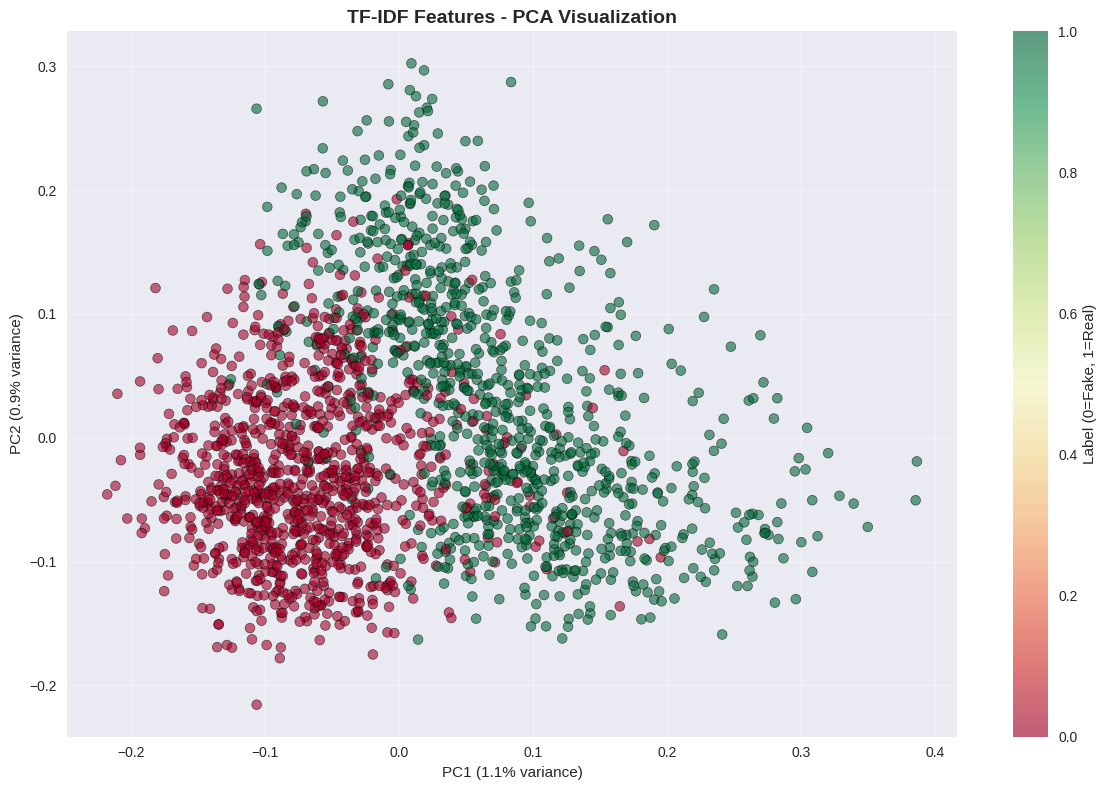

Total variance explained: 2.0%


In [7]:
# Reduce TF-IDF features to 2D using PCA
from sklearn.decomposition import PCA

# Sample for faster visualization
sample_indices = np.random.choice(X_tfidf.shape[0], size=min(2000, X_tfidf.shape[0]), replace=False)
X_tfidf_sample = X_tfidf[sample_indices].toarray()
y_tfidf_sample = y[sample_indices]

# Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf_sample)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y_tfidf_sample, 
                     cmap='RdYlGn', 
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Label (0=Fake, 1=Real)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('TF-IDF Features - PCA Visualization', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

## 5. Feature Visualization with t-SNE

Running t-SNE (this may take a minute)...


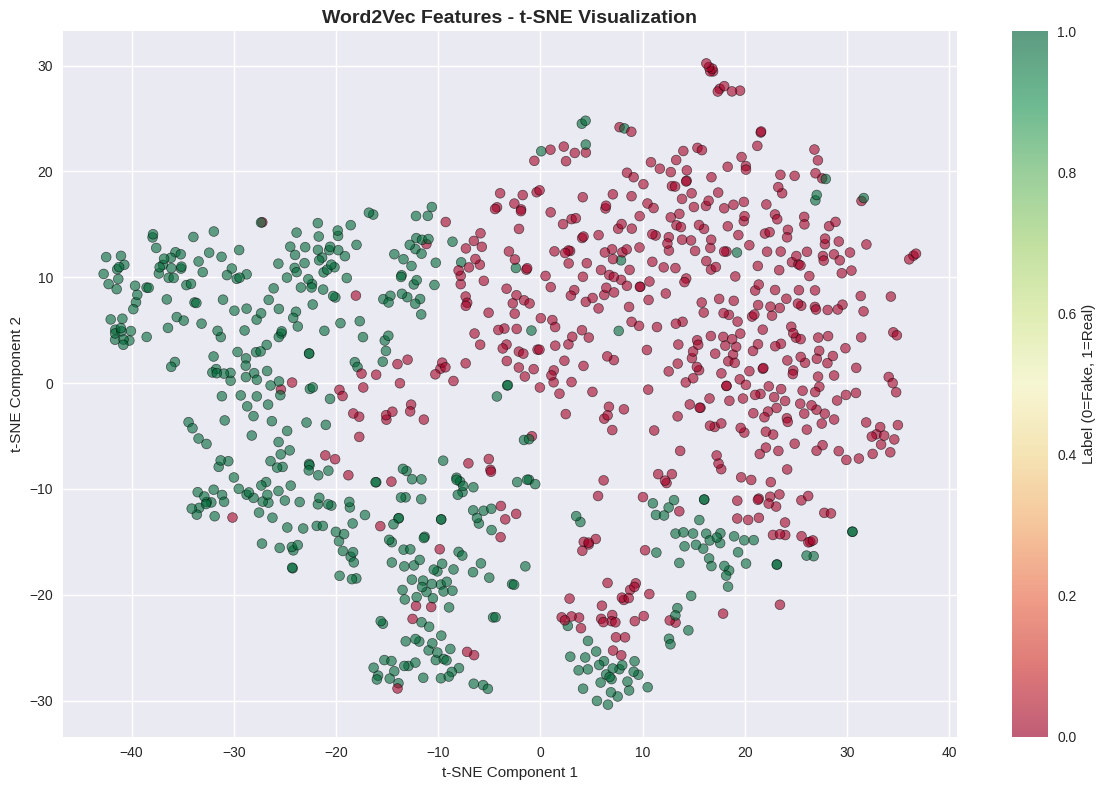

In [8]:
from sklearn.manifold import TSNE

# Use even smaller sample for t-SNE (it's slow)
tsne_sample_size = min(1000, len(X_w2v))
sample_idx = np.random.choice(len(X_w2v), tsne_sample_size, replace=False)
X_w2v_sample = X_w2v[sample_idx]
y_w2v_sample = y_sample[sample_idx]

# Apply t-SNE
print("Running t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_w2v_sample)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1],
                     c=y_w2v_sample,
                     cmap='RdYlGn',
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)
plt.colorbar(scatter, label='Label (0=Fake, 1=Real)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Word2Vec Features - t-SNE Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Feature Statistics Comparison

Feature Extraction Methods Comparison:
  Method  Dimensions Sparsity   Type
  TF-IDF        5000    97.2% Sparse
Word2Vec         100     0.0%  Dense


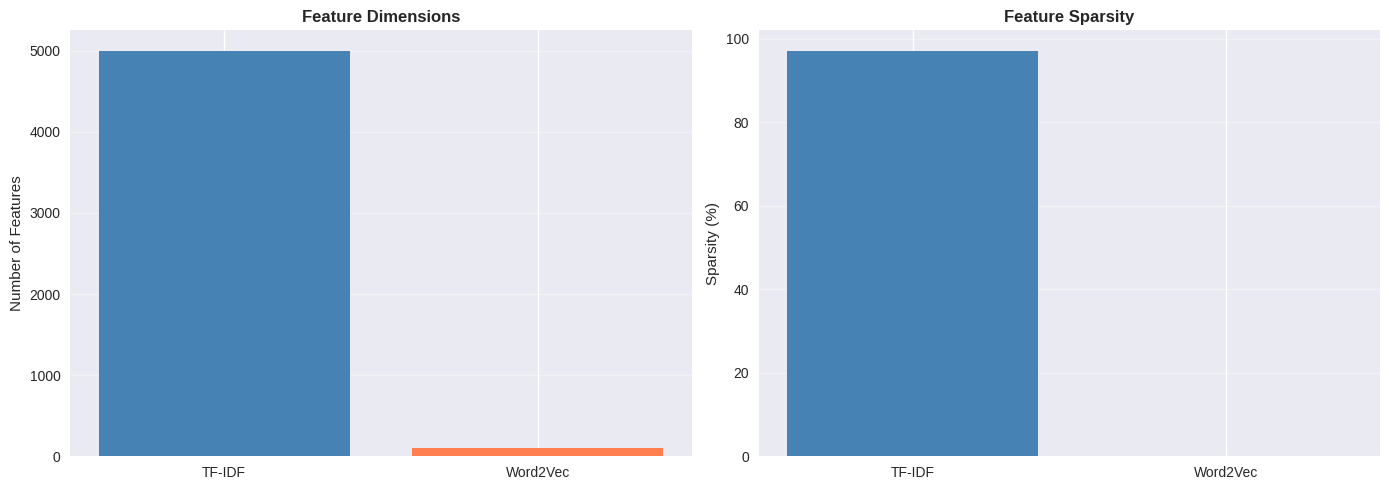

In [9]:
# Compare feature representations
feature_comparison = pd.DataFrame({
    'Method': ['TF-IDF', 'Word2Vec'],
    'Dimensions': [X_tfidf.shape[1], X_w2v.shape[1]],
    'Sparsity': [
        f"{(1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])):.1%}",
        f"{(X_w2v == 0).sum() / X_w2v.size:.1%}"
    ],
    'Type': ['Sparse', 'Dense']
})

print("Feature Extraction Methods Comparison:")
print("="*70)
print(feature_comparison.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dimensions
axes[0].bar(['TF-IDF', 'Word2Vec'], 
           [X_tfidf.shape[1], X_w2v.shape[1]],
           color=['steelblue', 'coral'])
axes[0].set_ylabel('Number of Features')
axes[0].set_title('Feature Dimensions', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Sparsity
sparsity_tfidf = 1 - X_tfidf.nnz / (X_tfidf.shape[0] * X_tfidf.shape[1])
sparsity_w2v = (X_w2v == 0).sum() / X_w2v.size
axes[1].bar(['TF-IDF', 'Word2Vec'],
           [sparsity_tfidf * 100, sparsity_w2v * 100],
           color=['steelblue', 'coral'])
axes[1].set_ylabel('Sparsity (%)')
axes[1].set_title('Feature Sparsity', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Features for Model Training

In [10]:
# Save TF-IDF vectorizer and Word2Vec model
tfidf.save('tfidf_vectorizer.pkl')
w2v.save('word2vec_model.pkl')

print("✅ Feature extractors saved!")
print("\nSaved models:")
print("  - models/tfidf_vectorizer.pkl")
print("  - models/word2vec_model.pkl")

💾 TF-IDF vectorizer saved to /home/fograin/Serenity/AUPP/ITM-454_NLP/Final_Project/fyp-NLP/notebooks/../models/tfidf_vectorizer.pkl
💾 Word2Vec model saved to /home/fograin/Serenity/AUPP/ITM-454_NLP/Final_Project/fyp-NLP/notebooks/../models/word2vec_model.pkl
✅ Feature extractors saved!

Saved models:
  - models/tfidf_vectorizer.pkl
  - models/word2vec_model.pkl


## Summary

### Key Findings:

1. **TF-IDF**:
   - High-dimensional sparse features
   - Captures term importance
   - Good for traditional ML models

2. **Word2Vec**:
   - Lower-dimensional dense features
   - Captures semantic relationships
   - Good for neural networks

### Next Steps:

1. Run feature extraction pipeline: `python src/preprocessing/extract_features.py`
2. Proceed to Phase 4: Model Development
3. Train and compare different models